In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras import layers, models

# ========== STEP 0: Set working directory (for running locally on laptop) =========
os.getcwd()
os.chdir("/Users/adeslatt/Scitechcon Dropbox/Anne DeslattesMays/projects/oadr-autoantibody")
os.getcwd()

'/Users/adeslatt/Scitechcon Dropbox/Anne DeslattesMays/projects/oadr-autoantibody'

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from tensorflow.keras import layers, models

def train_and_evaluate_from_tidy(df, study_list, study_name, max_features=5, epochs=50):
    print(f"\n===== Training CNN Autoencoder for {study_name} =====")

    # --- 1. Normalize input ---
    if isinstance(study_list, str):
        study_list = [study_list]

    # --- 2. Filter by study ---
    df_filtered = df[df["Study"].isin(study_list)].copy()
    print(f"Filtered samples: {df_filtered.shape[0]} rows")

    if df_filtered.empty:
        raise ValueError(f"No data found for study list: {study_list}")

    # --- 3. Normalize antibody names ---
    df_filtered["Property"] = (
        df_filtered["Property"]
        .str.upper()
        .str.replace(r"[^A-Z0-9]", "", regex=True)
    )

    # --- 4. Pivot to wide format ---
    df_wide = df_filtered.pivot_table(
        index="Accession",
        columns="Property",
        values="Value",
        aggfunc="first"
    ).fillna(0).sort_index(axis=1)

#    antibody_labels = df_wide.columns.tolist()
    expected_ab = ["GAD65", "IA2IC", "MIAA", "ICA", "ZNT8"]
    df_wide = df_wide.reindex(columns=expected_ab, fill_value=0)
    antibody_labels = df_wide.columns.tolist()

    print(f"Detected {len(antibody_labels)} antibodies: {antibody_labels}")

    # --- 5. Add age_group and sex to df_wide ---
    demo_cols = df_filtered[["Accession", "Age_Group", "Sex"]].drop_duplicates().set_index("Accession")
    df_wide = df_wide.join(demo_cols, how="left")

    # --- 6. Limit antibodies to max_features (pad if needed) ---
    X_ab = df_wide[antibody_labels].values
    if X_ab.shape[1] < max_features:
        pad = max_features - X_ab.shape[1]
        X_ab = np.pad(X_ab, ((0,0),(0,pad)), mode="constant")
        antibody_labels += [f"PAD_{i}" for i in range(pad)]

    # --- 7. MinMax scale antibody features ---
    ab_scaler = MinMaxScaler()
    X_ab_scaled = ab_scaler.fit_transform(X_ab)

    # --- 8. One-hot encode demographics ---
    demo_array = df_wide[["Age_Group", "Sex"]].fillna("missing").astype(str).values
    encoder = OneHotEncoder(sparse_output=False)
    X_demo = encoder.fit_transform(demo_array)

    # --- 9. Combine features ---
    X_full = np.hstack([X_ab_scaled, X_demo])

    # --- 10. Train/test split (track indices) ---
    indices = np.arange(X_full.shape[0])
    X_train, X_test, idx_train, idx_test = train_test_split(
        X_full, indices, test_size=0.2, random_state=42
    )
    X_test_indices = df_wide.index[idx_test]

    # --- 11. Reshape for CNN ---
    X_train_reshaped = X_train[:, :max_features].reshape(-1, max_features, 1, 1)
    X_test_reshaped  = X_test[:, :max_features].reshape(-1, max_features, 1, 1)

    # --- 12. Define CNN autoencoder ---
    input_layer = layers.Input(shape=(max_features, 1, 1))
    x = layers.Conv2D(4, (3, 1), activation="relu", padding="same")(input_layer)
    x = layers.Flatten()(x)
    encoded = layers.Dense(2, activation="relu")(x)
    x = layers.Dense(max_features * 1 * 4, activation="relu")(encoded)
    x = layers.Reshape((max_features, 1, 4))(x)
    decoded = layers.Conv2D(1, (3, 1), activation="linear", padding="same")(x)

    autoencoder = models.Model(input_layer, decoded)
    autoencoder.compile(optimizer="adam", loss="mse")

    # --- 13. Train model ---
    autoencoder.fit(
        X_train_reshaped, X_train_reshaped,
        epochs=epochs, batch_size=8,
        validation_data=(X_test_reshaped, X_test_reshaped),
        verbose=0
    )

    # --- 14. Predict and flatten ---
    reconstructed = autoencoder.predict(X_test_reshaped)

    # === Save model and weights ===
    model_dir = "models"
    os.makedirs(model_dir, exist_ok=True)
    model_path = os.path.join(model_dir, f"{study_name}_model.keras")
    weights_path = os.path.join(model_dir, f"{study_name}.weights.h5")
    
    autoencoder.save(model_path)
    autoencoder.save_weights(weights_path)
    print(f"Saved model:    {model_path}")
    print(f"Saved weights:  {weights_path}")

    reconstructed_flat = reconstructed.reshape(X_test[:, :max_features].shape)

    # --- 15. Per-antibody MSE ---
    per_antibody_mse = {}
    for i, ab in enumerate(antibody_labels[:max_features]):
        per_antibody_mse[ab] = mean_squared_error(X_test[:, i], reconstructed_flat[:, i])

    # --- 16. Summary statistics ---
    all_mse = list(per_antibody_mse.values())
    mse_median = np.median(all_mse)
    mse_iqr = np.percentile(all_mse, 75) - np.percentile(all_mse, 25)

    print(f"Median MSE: {mse_median:.4f}")
    print(f"IQR:        {mse_iqr:.4f}")

    return {
        "mse_median": mse_median,
        "mse_iqr": mse_iqr,
        "per_antibody_mse": per_antibody_mse,
        "X_train": X_train, 
        "X_test": X_test[:, :max_features],
        "reconstructed": reconstructed_flat,
        "antibody_labels": antibody_labels[:max_features],
        "Age_Group": df_wide.loc[X_test_indices, "Age_Group"].values,
        "Sex": df_wide.loc[X_test_indices, "Sex"].values
    }


In [3]:
import pandas as pd

# === 1. Load the full tidy dataset ===
df_all = pd.read_csv("data/tidy_all.csv")

# === 2. Define your study list ===
study_list = ["SDY569", "SDY1625", "SDY524", "SDY797", "SDY1737"]

# === 3. Train and evaluate each study individually ===
mse_summaries = {}

for study in study_list:
    print(f"\n--- Training on {study} ---")
    result = train_and_evaluate_from_tidy(
        df=df_all,
        study_list=[study],           # must be a list
        study_name=study,             # name used for model file
        max_features=7,
        epochs=50
    )
    mse_summaries[study] = result



--- Training on SDY569 ---

===== Training CNN Autoencoder for SDY569 =====
Filtered samples: 30 rows
Detected 5 antibodies: ['GAD65', 'IA2IC', 'MIAA', 'ICA', 'ZNT8']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Saved model:    models/SDY569_model.keras
Saved weights:  models/SDY569.weights.h5
Median MSE: 0.0013
IQR:        0.0014

--- Training on SDY1625 ---

===== Training CNN Autoencoder for SDY1625 =====
Filtered samples: 84 rows
Detected 5 antibodies: ['GAD65', 'IA2IC', 'MIAA', 'ICA', 'ZNT8']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Saved model:    models/SDY1625_model.keras
Saved weights:  models/SDY1625.weights.h5
Median MSE: 0.0014
IQR:        0.0134

--- Training on SDY524 ---

===== Training CNN Autoencoder for SDY524 =====
Filtered samples: 300 rows
Detected 5 antibodies: ['GAD65', 'IA2IC', 'MIAA', 'ICA', 'ZNT8']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Saved model:    models/SDY524_model.keras
Saved weights:  models/SDY524.weights.h5
Median MSE: 0.0100
IQR:        0.0598

--- Training 

In [4]:

# === 4. Save the mse_summaries for federated analysis simulation

import pickle

# Save mse_summaries as a pickle file
with open("data/mse_summaries.pkl", "wb") as f:
    pickle.dump(mse_summaries, f)


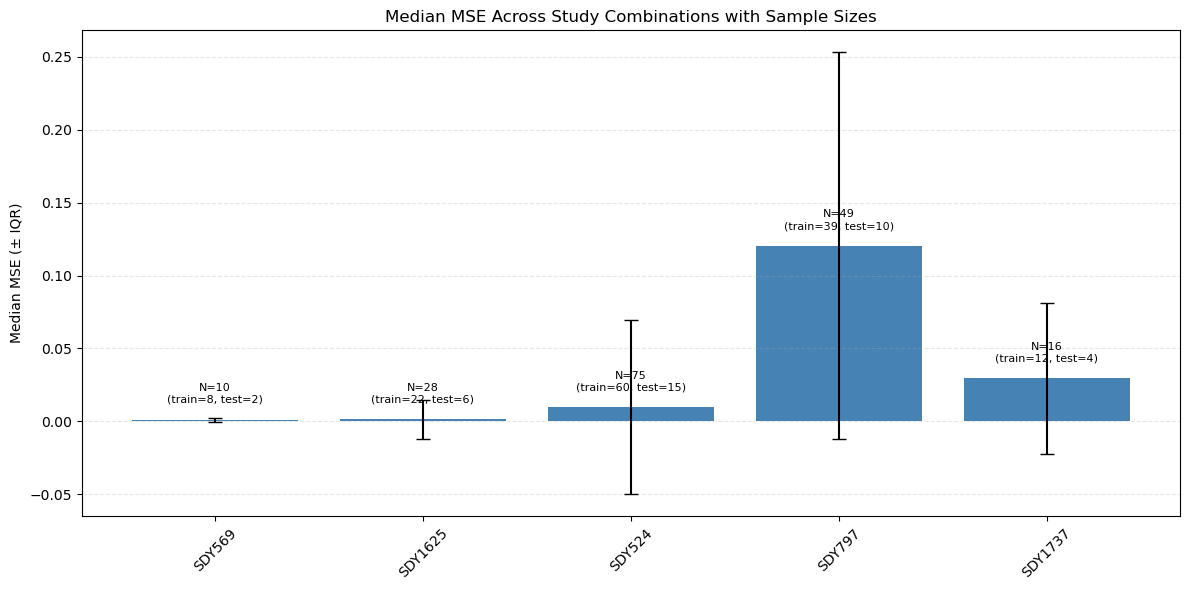

In [5]:
import matplotlib.pyplot as plt

# Get values from mse_summaries
study_names = list(mse_summaries.keys())
medians = [mse_summaries[study]["mse_median"] for study in study_names]
iqrs = [mse_summaries[study]["mse_iqr"] for study in study_names]
train_sizes = [mse_summaries[study]["X_train"].shape[0] for study in study_names]
test_sizes = [mse_summaries[study]["X_test"].shape[0] for study in study_names]

# Bar plot
fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(study_names, medians, yerr=iqrs, capsize=5, color='steelblue')

# Annotate N on top of bars
for bar, train, test in zip(bars, train_sizes, test_sizes):
    height = bar.get_height()
    label = f"N={train+test}\n(train={train}, test={test})"
    ax.text(bar.get_x() + bar.get_width() / 2, height + 0.01, label,
            ha='center', va='bottom', fontsize=8)

# Formatting
ax.set_ylabel("Median MSE (± IQR)")
ax.set_title("Median MSE Across Study Combinations with Sample Sizes")
ax.set_xticks(range(len(study_names)))
ax.set_xticklabels(study_names, rotation=45)
ax.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


In [6]:
for study, summary in mse_summaries.items():
    print(f"\nStudy: {study}")
    print("  Age groups:", summary.get("Age_Group", None))
    print("  Sex:", summary.get("Sex", None))



Study: SDY569
  Age groups: ['8-12' '18-30']
  Sex: ['Female' 'Male']

Study: SDY1625
  Age groups: ['8-12' '8-12' '8-12' '8-12' '8-12' '8-12']
  Sex: ['Female' 'Male' 'Female' 'Male' 'Male' 'Female']

Study: SDY524
  Age groups: ['8-12' '13-17' '8-12' '8-12' '8-12' '8-12' '8-12' '8-12' '8-12' '13-17'
 '13-17' '8-12' '13-17' '8-12' '8-12']
  Sex: ['Female' 'Female' 'Male' 'Male' 'Female' 'Male' 'Female' 'Male' 'Male'
 'Male' 'Male' 'Female' 'Male' 'Male' 'Male']

Study: SDY797
  Age groups: ['8-12' '8-12' '8-12' '8-12' '8-12' '8-12' '8-12' '8-12' '8-12' '8-12']
  Sex: ['Male' 'Male' 'Male' 'Female' 'Male' 'Male' 'Male' 'Male' 'Female' 'Male']

Study: SDY1737
  Age groups: ['13-17' '8-12' '13-17' '8-12']
  Sex: ['Female' 'Female' 'Male' 'Female']


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_mse_by_sex(mse_summaries):
    data = []

    for study, summary in mse_summaries.items():
        mse = mean_squared_error(summary["X_test"], summary["reconstructed"])
        sexes = summary["Sex"]
        for i, s in enumerate(sexes):
            data.append({
                "Study": study,
                "Sex": s,
                "MSE": np.mean((summary["X_test"][i] - summary["reconstructed"][i])**2)
            })

    df_plot = pd.DataFrame(data)
    plt.figure(figsize=(10, 5))
    sns.barplot(data=df_plot, x="Study", y="MSE", hue="Sex")
    plt.title("MSE by Sex per Study")
    plt.tight_layout()
    plt.show()


In [8]:
def plot_mse_by_age_group(mse_summaries):
    data = []

    for study, summary in mse_summaries.items():
        mse = mean_squared_error(summary["X_test"], summary["reconstructed"])
        ages = summary["Age_Group"]
        for i, age in enumerate(ages):
            data.append({
                "Study": study,
                "Age_Group": age,
                "MSE": np.mean((summary["X_test"][i] - summary["reconstructed"][i])**2)
            })

    df_plot = pd.DataFrame(data)
    plt.figure(figsize=(12, 6))
    sns.barplot(data=df_plot, x="Study", y="MSE", hue="Age_Group")
    plt.title("MSE by Age Group per Study")
    plt.tight_layout()
    plt.show()


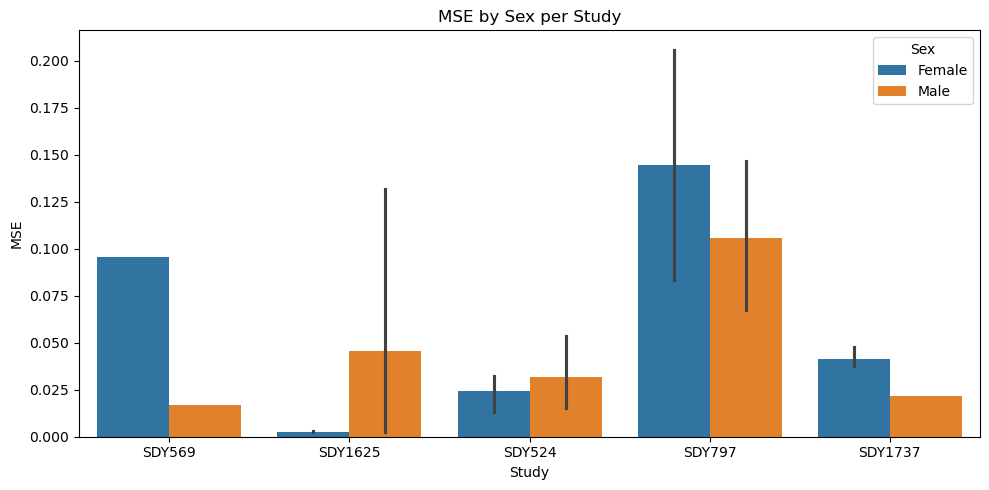

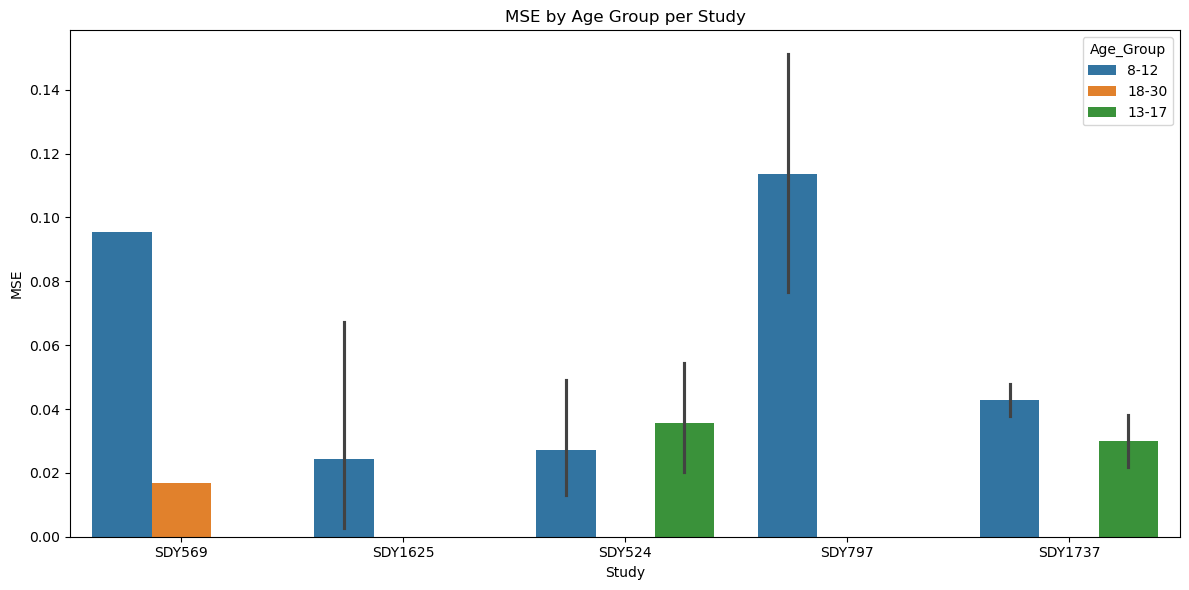

In [9]:
plot_mse_by_sex(mse_summaries)
plot_mse_by_age_group(mse_summaries)


In [10]:
def plot_antibody_mse_by_sex(mse_summaries):
    data = []

    for study, summary in mse_summaries.items():
        X_test = summary["X_test"]
        X_recon = summary["reconstructed"]
        antibodies = summary["antibody_labels"]
        sexes = summary["Sex"]

        for i in range(len(X_test)):
            for j, ab in enumerate(antibodies):
                data.append({
                    "Study": study,
                    "Sex": sexes[i],
                    "Antibody": ab,
                    "MSE": (X_test[i, j] - X_recon[i, j]) ** 2
                })

    df = pd.DataFrame(data)
    plt.figure(figsize=(14, 6))
    sns.boxplot(data=df, x="Antibody", y="MSE", hue="Sex")
    plt.title("Per-Antibody MSE Stratified by Sex")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [11]:
def plot_antibody_mse_by_age_group(mse_summaries):
    data = []

    for study, summary in mse_summaries.items():
        X_test = summary["X_test"]
        X_recon = summary["reconstructed"]
        antibodies = summary["antibody_labels"]
        ages = summary["Age_Group"]

        for i in range(len(X_test)):
            for j, ab in enumerate(antibodies):
                data.append({
                    "Study": study,
                    "Age_Group": ages[i],
                    "Antibody": ab,
                    "MSE": (X_test[i, j] - X_recon[i, j]) ** 2
                })

    df = pd.DataFrame(data)
    plt.figure(figsize=(14, 6))
    sns.boxplot(data=df, x="Antibody", y="MSE", hue="Age_Group")
    plt.title("Per-Antibody MSE Stratified by Age Group")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


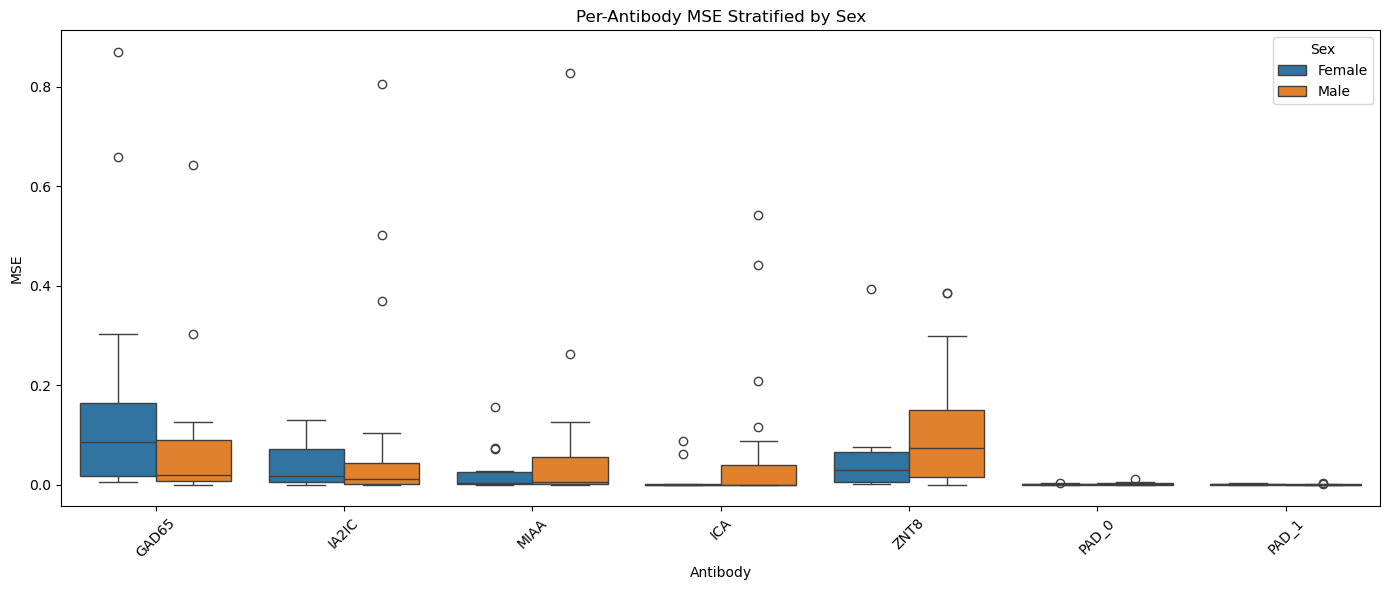

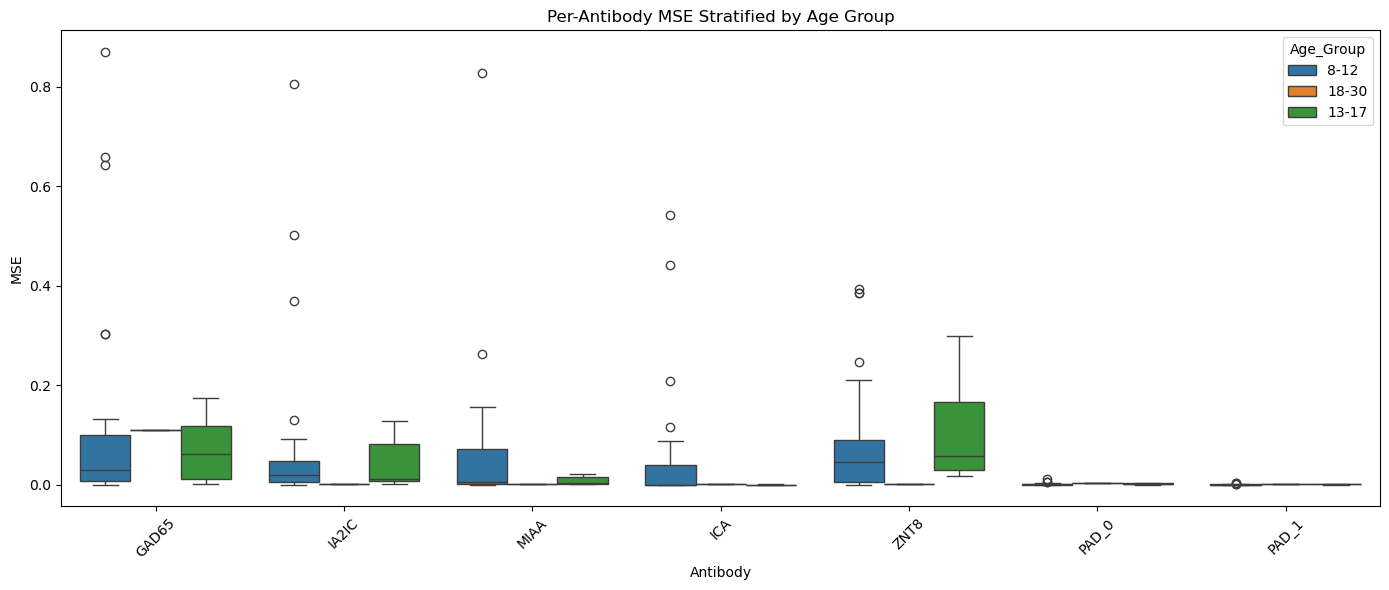

In [12]:
plot_antibody_mse_by_sex(mse_summaries)
plot_antibody_mse_by_age_group(mse_summaries)


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_per_study_mse_stratified(mse_summaries, stratify_by="Sex"):
    for study, summary in mse_summaries.items():
        X_test = summary["X_test"]
        X_recon = summary["reconstructed"]
        antibodies = summary["antibody_labels"]
        strat_vals = summary[stratify_by]

        data = []
        for i in range(len(X_test)):
            for j, ab in enumerate(antibodies):
                data.append({
                    "Study": study,
                    stratify_by: strat_vals[i],
                    "Antibody": ab,
                    "MSE": (X_test[i, j] - X_recon[i, j]) ** 2
                })

        df = pd.DataFrame(data)
        plt.figure(figsize=(12, 6))
        ax = sns.boxplot(data=df, x="Antibody", y="MSE", hue=stratify_by)
        plt.title(f"{study}: MSE by {stratify_by} for Each Autoantibody")
        plt.xticks(rotation=45)

        # Add N annotations
        group_counts = df.groupby(["Antibody", stratify_by]).size().reset_index(name='N')
        for i, group in group_counts.iterrows():
            ab = group["Antibody"]
            strat = group[stratify_by]
            count = group["N"]

            # Find the correct position on the plot
            xpos = list(df["Antibody"].unique()).index(ab)
            offset = -0.2 if strat == df[stratify_by].unique()[0] else 0.2
            ax.text(xpos + offset, df["MSE"].max() * 1.05, f"N={count}", 
                    ha='center', va='bottom', fontsize=8, rotation=90)

        plt.tight_layout()
        plt.show()


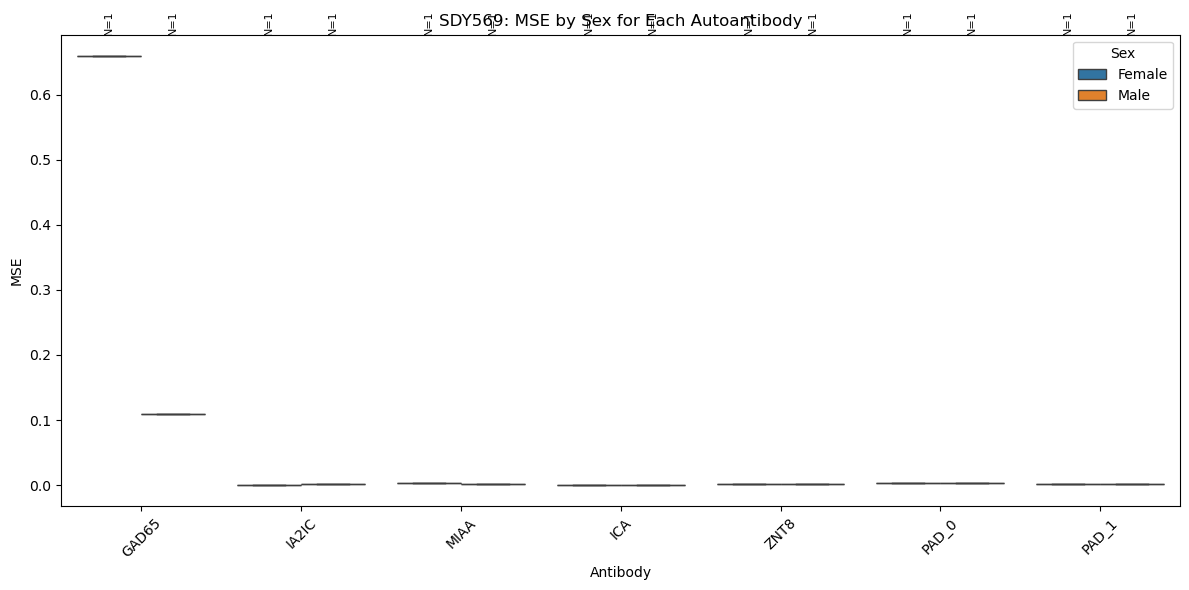

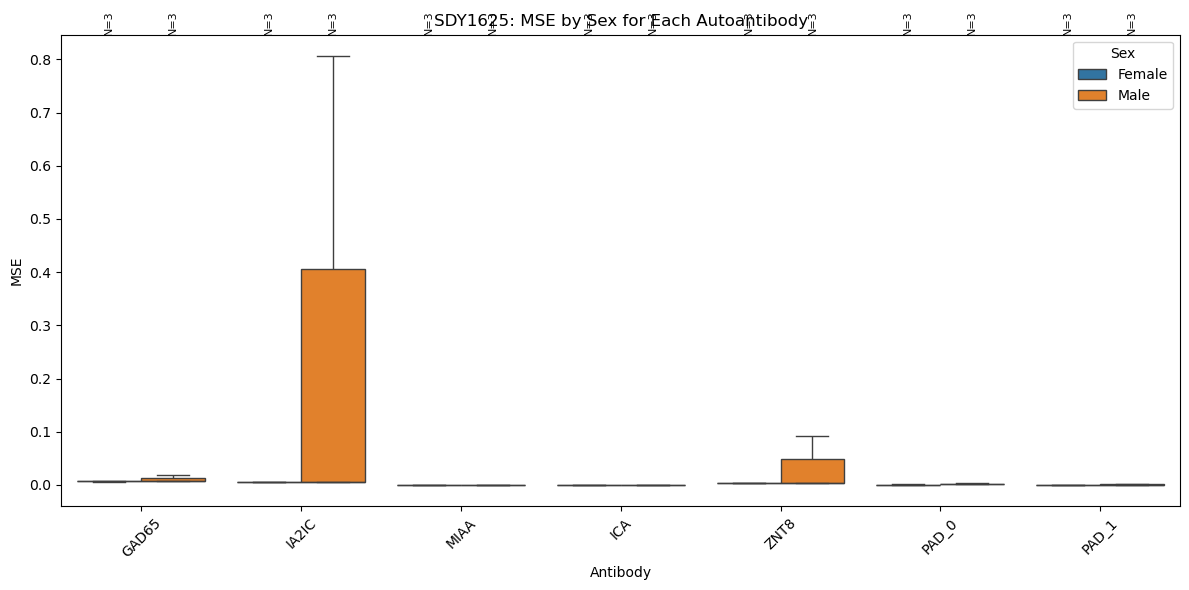

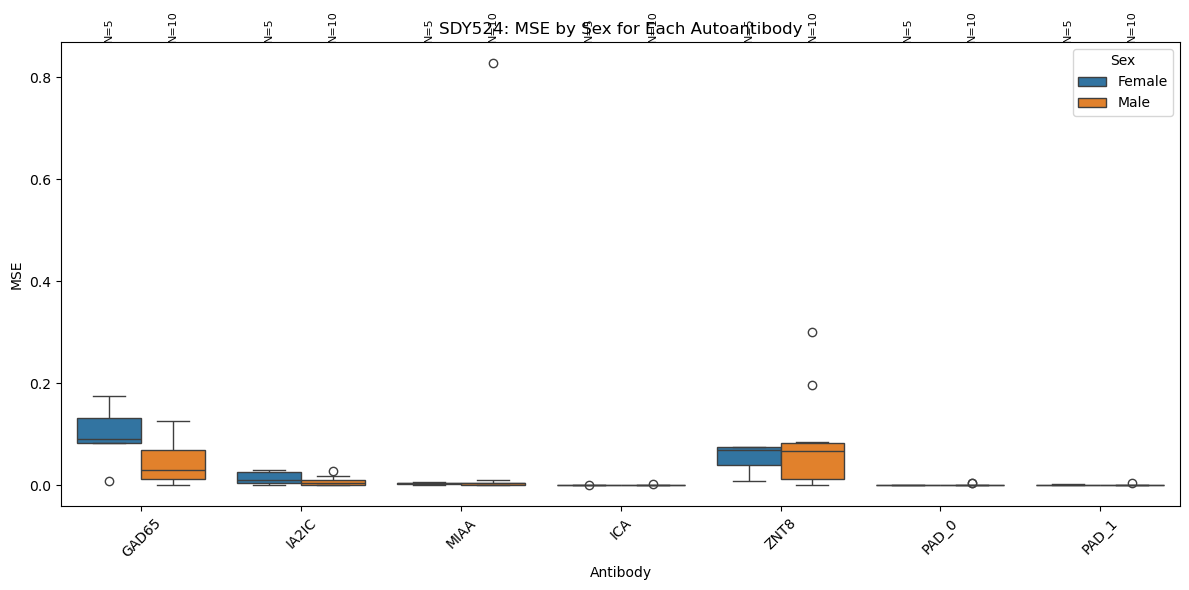

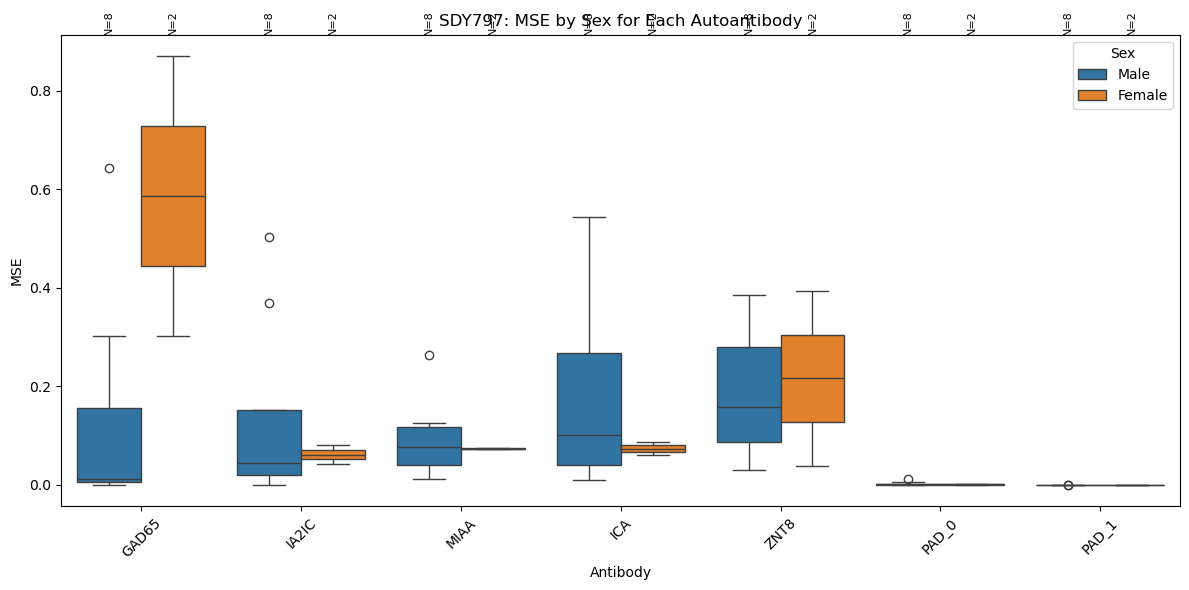

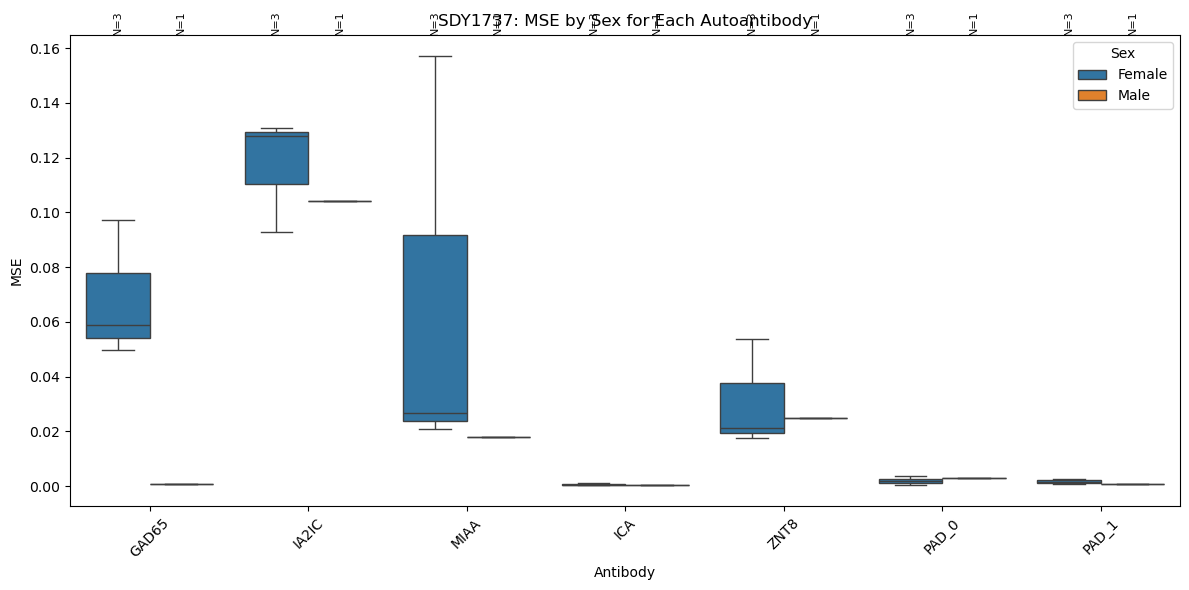

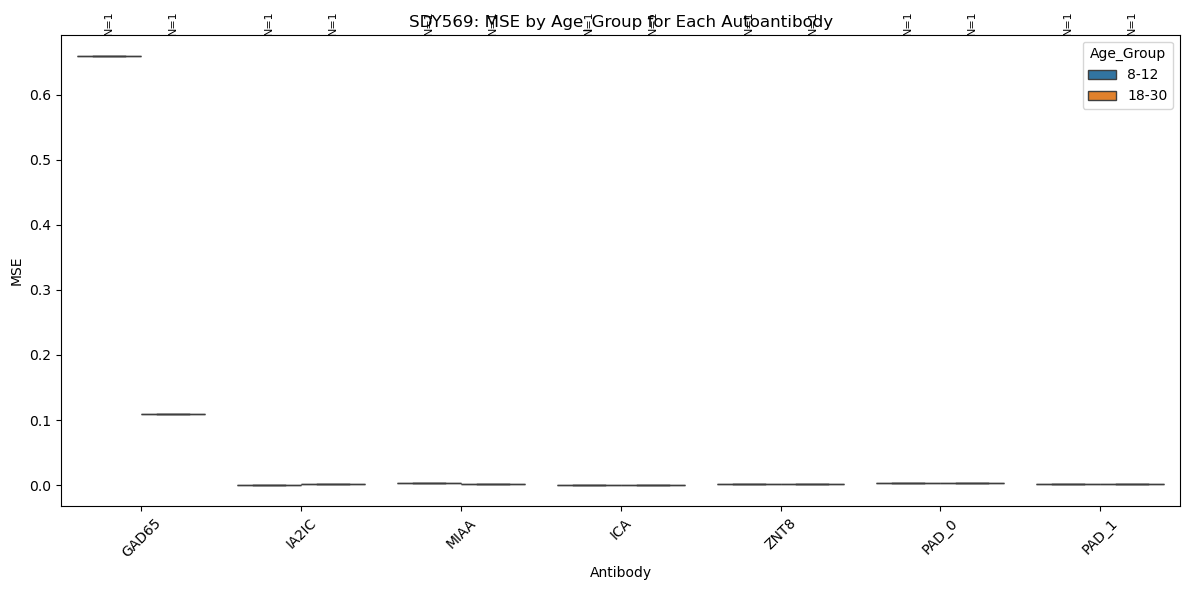

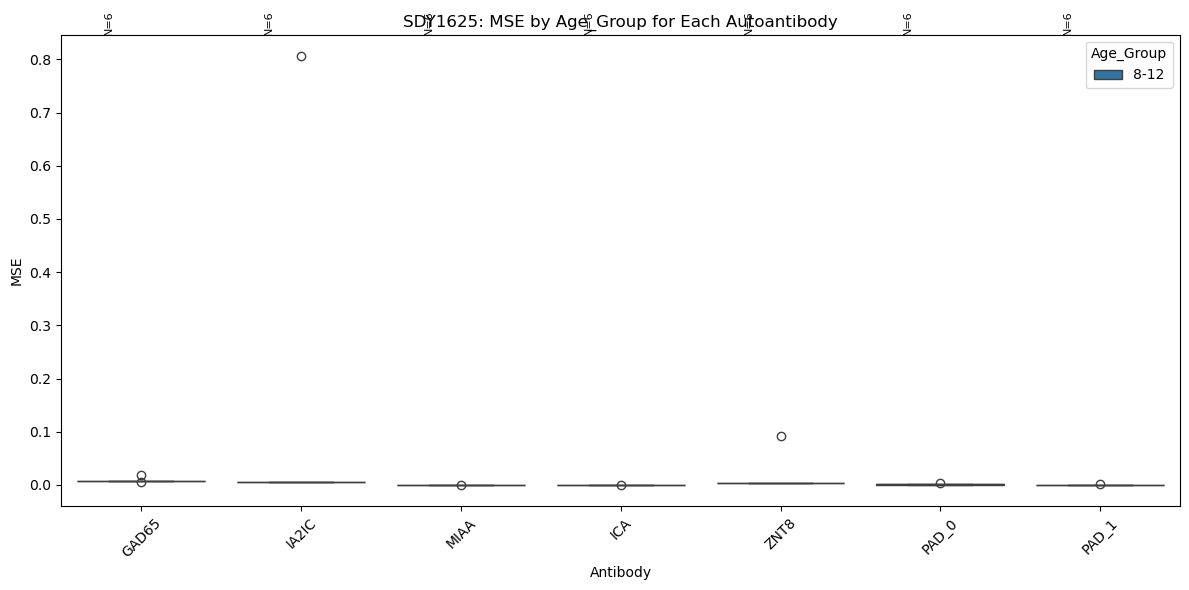

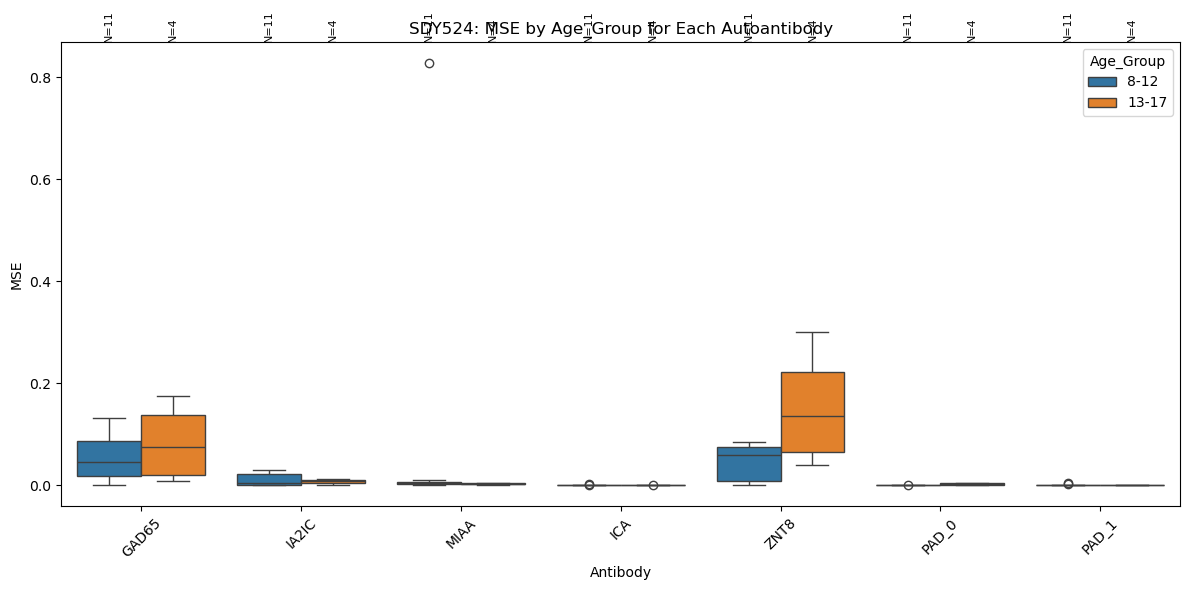

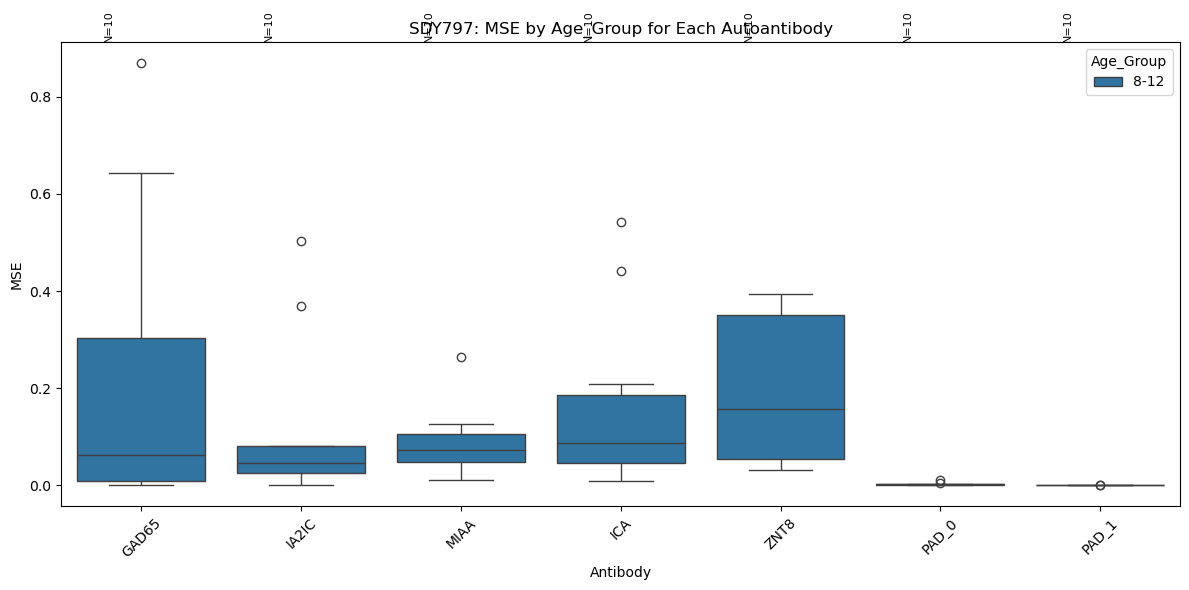

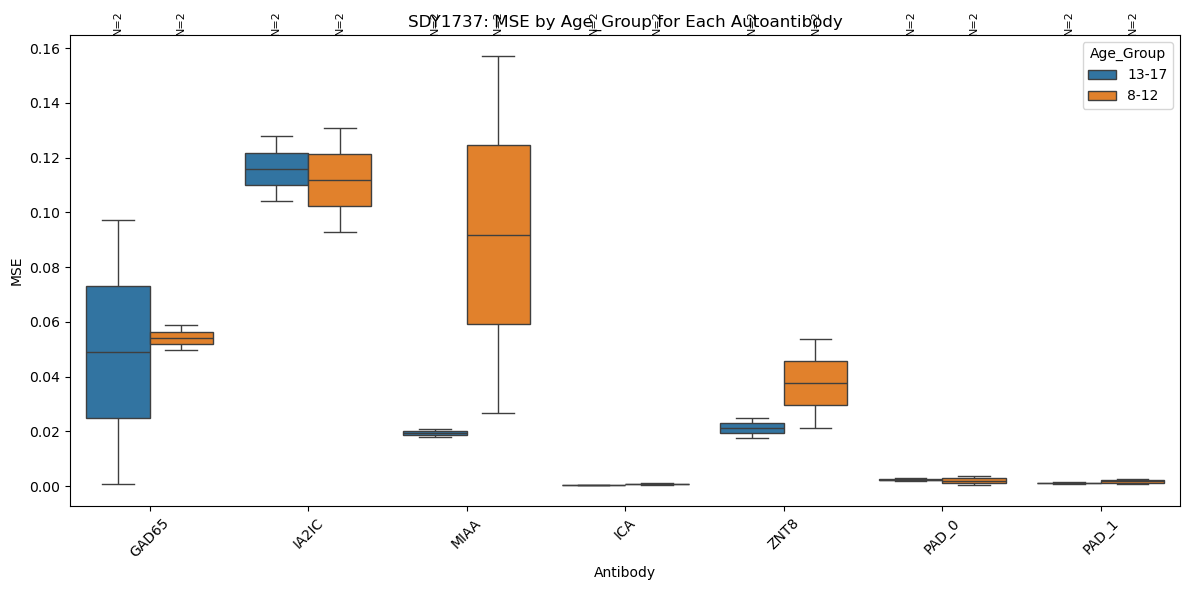

In [14]:
plot_per_study_mse_stratified(mse_summaries, stratify_by="Sex")
plot_per_study_mse_stratified(mse_summaries, stratify_by="Age_Group")


In [15]:
def antibody_mse_across_studies(mse_summaries, stratify_by="Sex"):
    rows = []

    for study, summary in mse_summaries.items():
        X_test = summary["X_test"]
        X_recon = summary["reconstructed"]
        antibodies = summary["antibody_labels"]
        strat_vals = summary[stratify_by]

        for i in range(len(X_test)):
            for j, ab in enumerate(antibodies):
                rows.append({
                    "Study": study,
                    "Antibody": ab,
                    stratify_by: strat_vals[i],
                    "MSE": (X_test[i, j] - X_recon[i, j]) ** 2
                })

    df = pd.DataFrame(rows)
    plt.figure(figsize=(14, 6))
    ax = sns.boxplot(data=df, x="Antibody", y="MSE", hue="Study")
    plt.title(f"MSE per Autoantibody Across Studies (stratified by {stratify_by})")
    plt.xticks(rotation=45)

    # Add N counts
    group_counts = df.groupby(["Antibody", "Study"]).size().reset_index(name='N')
    for i, group in group_counts.iterrows():
        ab = group["Antibody"]
        study = group["Study"]
        count = group["N"]

        xpos = list(df["Antibody"].unique()).index(ab)
        offset = -0.3 + 0.1 * list(df["Study"].unique()).index(study)
        ax.text(xpos + offset, df["MSE"].max() * 1.05, f"N={count}",
                ha='center', va='bottom', fontsize=8, rotation=90)

    plt.tight_layout()
    plt.show()


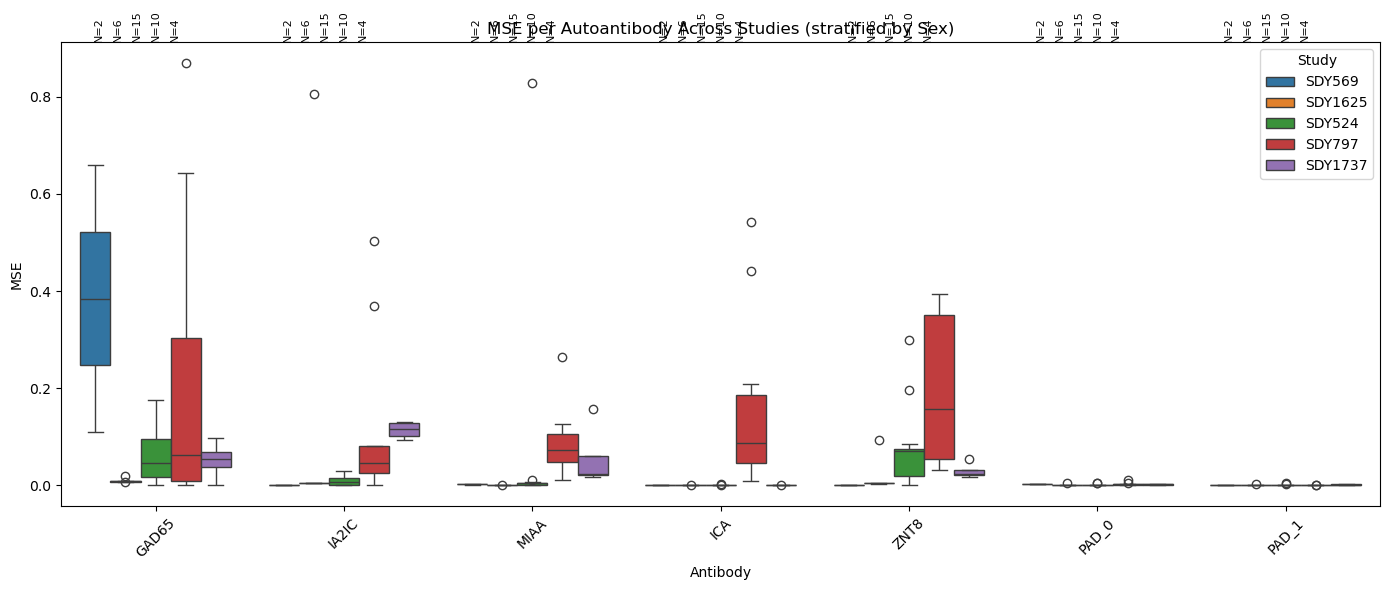

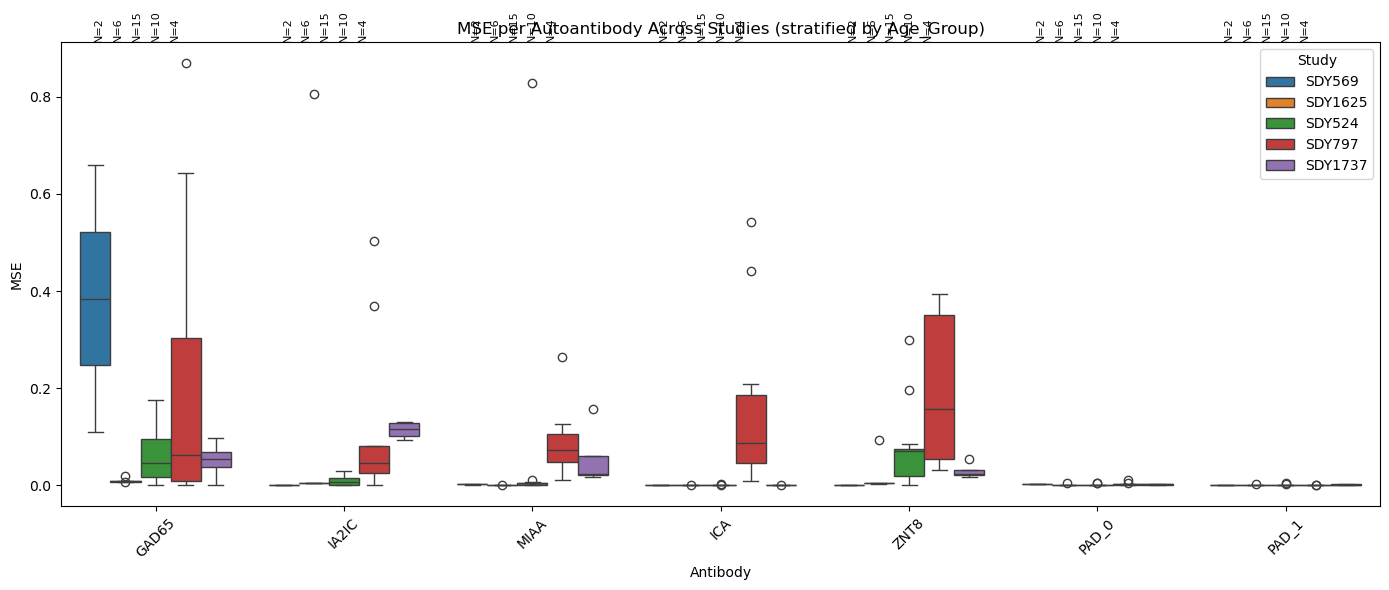

In [16]:
antibody_mse_across_studies(mse_summaries, stratify_by="Sex")
antibody_mse_across_studies(mse_summaries, stratify_by="Age_Group")

In [17]:
import os
os.makedirs("plots", exist_ok=True)


In [18]:
def plot_per_study_mse_stratified(mse_summaries, stratify_by="Sex"):
    for study, summary in mse_summaries.items():
        X_test = summary["X_test"]
        X_recon = summary["reconstructed"]
        antibodies = summary["antibody_labels"]
        strat_vals = summary[stratify_by]

        data = []
        for i in range(len(X_test)):
            for j, ab in enumerate(antibodies):
                data.append({
                    "Study": study,
                    stratify_by: strat_vals[i],
                    "Antibody": ab,
                    "MSE": (X_test[i, j] - X_recon[i, j]) ** 2
                })

        df = pd.DataFrame(data)
        plt.figure(figsize=(12, 6))
        ax = sns.boxplot(data=df, x="Antibody", y="MSE", hue=stratify_by)
        plt.title(f"{study}: MSE by {stratify_by} for Each Autoantibody")
        plt.xticks(rotation=45)

        # Add N annotations
        group_counts = df.groupby(["Antibody", stratify_by]).size().reset_index(name='N')
        for _, group in group_counts.iterrows():
            ab = group["Antibody"]
            strat = group[stratify_by]
            count = group["N"]

            xpos = list(df["Antibody"].unique()).index(ab)
            offset = -0.2 if strat == df[stratify_by].unique()[0] else 0.2
            ax.text(xpos + offset, df["MSE"].max() * 1.05, f"N={count}",
                    ha='center', va='bottom', fontsize=8, rotation=90)

        plt.tight_layout()
        plt.savefig(f"plots/{study}_mse_by_{stratify_by}.png")
        plt.show()


In [19]:
def antibody_mse_across_studies(mse_summaries, stratify_by="Sex"):
    rows = []

    for study, summary in mse_summaries.items():
        X_test = summary["X_test"]
        X_recon = summary["reconstructed"]
        antibodies = summary["antibody_labels"]
        strat_vals = summary[stratify_by]

        for i in range(len(X_test)):
            for j, ab in enumerate(antibodies):
                rows.append({
                    "Study": study,
                    "Antibody": ab,
                    stratify_by: strat_vals[i],
                    "MSE": (X_test[i, j] - X_recon[i, j]) ** 2
                })

    df = pd.DataFrame(rows)
    plt.figure(figsize=(14, 6))
    ax = sns.boxplot(data=df, x="Antibody", y="MSE", hue="Study")
    plt.title(f"MSE per Autoantibody Across Studies (stratified by {stratify_by})")
    plt.xticks(rotation=45)

    # Add N counts
    group_counts = df.groupby(["Antibody", "Study"]).size().reset_index(name='N')
    for _, group in group_counts.iterrows():
        ab = group["Antibody"]
        study = group["Study"]
        count = group["N"]

        xpos = list(df["Antibody"].unique()).index(ab)
        offset = -0.3 + 0.1 * list(df["Study"].unique()).index(study)
        ax.text(xpos + offset, df["MSE"].max() * 1.05, f"N={count}",
                ha='center', va='bottom', fontsize=8, rotation=90)

    plt.tight_layout()
    plt.savefig(f"plots/antibody_mse_across_studies_by_{stratify_by}.png")
    plt.show()


In [20]:
import matplotlib.pyplot as plt
import numpy as np

def plot_antibody_mse_by_demographics(mse_summaries, ymax=0.75):
    for study, summary in mse_summaries_3x3.items():
        antibody_labels = summary["antibody_labels"]
        X = summary["X_test"]
        Xr = summary["reconstructed"]
        age_groups = summary["Age_Group"]
        sexes = summary["Sex"]

        # --- Group by Age Group ---
        unique_ages = sorted(set(age_groups))
        fig_age, axes_age = plt.subplots(1, len(unique_ages), figsize=(6 * len(unique_ages), 5), sharey=True)
        if len(unique_ages) == 1:
            axes_age = [axes_age]
        for i, age in enumerate(unique_ages):
            idx = np.where(age_groups == age)[0]
            mse_by_ab = [
                np.mean((X[idx, j] - Xr[idx, j])**2) for j in range(len(antibody_labels))
            ]
            axes_age[i].bar(antibody_labels, mse_by_ab)
            axes_age[i].set_title(f"{study} - Age Group {age}")
            axes_age[i].set_ylabel("MSE")
            axes_age[i].set_ylim(0, ymax)
            axes_age[i].set_xticks(range(len(antibody_labels)))
            axes_age[i].set_xticklabels(antibody_labels, rotation=45)
        fig_age.suptitle(f"Per-Antibody MSE by Age Group — {study}", fontsize=14)
        plt.tight_layout()
        plt.show()

        # --- Group by Sex ---
        unique_sexes = sorted(set(sexes))
        fig_sex, axes_sex = plt.subplots(1, len(unique_sexes), figsize=(6 * len(unique_sexes), 5), sharey=True)
        if len(unique_sexes) == 1:
            axes_sex = [axes_sex]
        for i, sex in enumerate(unique_sexes):
            idx = np.where(sexes == sex)[0]
            mse_by_ab = [
                np.mean((X[idx, j] - Xr[idx, j])**2) for j in range(len(antibody_labels))
            ]
            axes_sex[i].bar(antibody_labels, mse_by_ab)
            axes_sex[i].set_title(f"{study} - Sex: {sex}")
            axes_sex[i].set_ylabel("MSE")
            axes_sex[i].set_ylim(0, ymax)
            axes_sex[i].set_xticks(range(len(antibody_labels)))
            axes_sex[i].set_xticklabels(antibody_labels, rotation=45)
        fig_sex.suptitle(f"Per-Antibody MSE by Sex — {study}", fontsize=14)
        plt.tight_layout()
        plt.show()


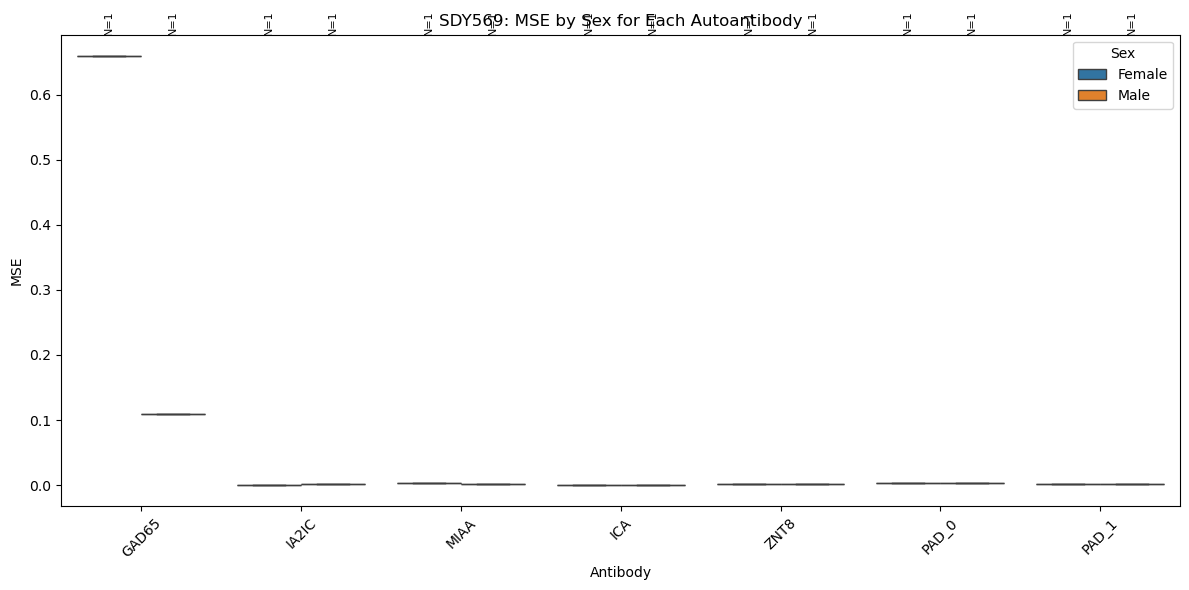

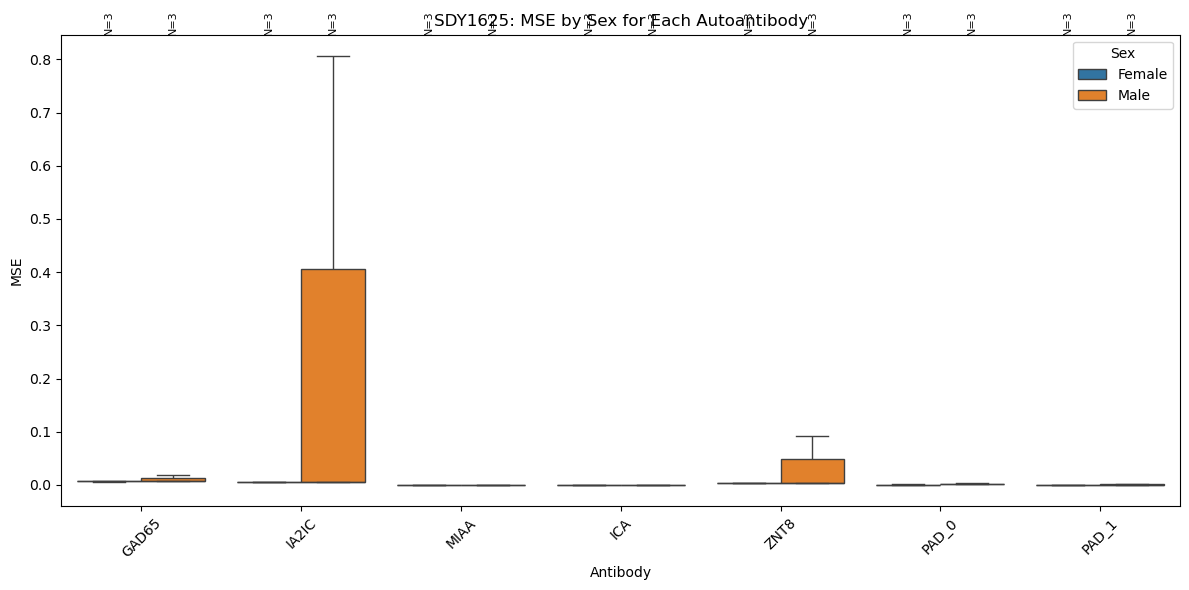

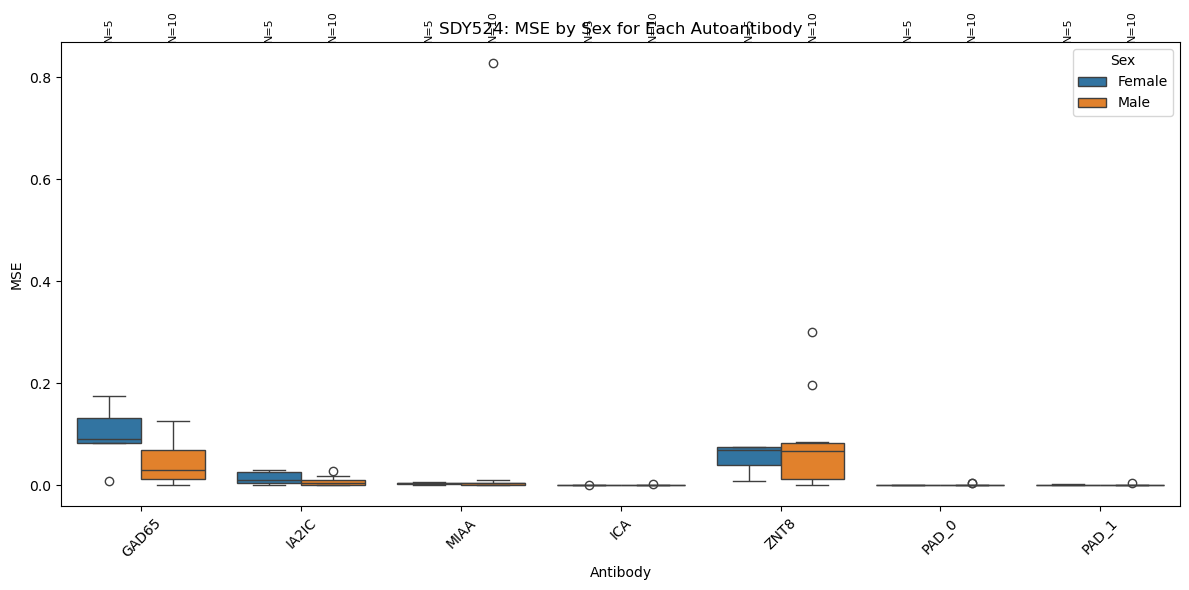

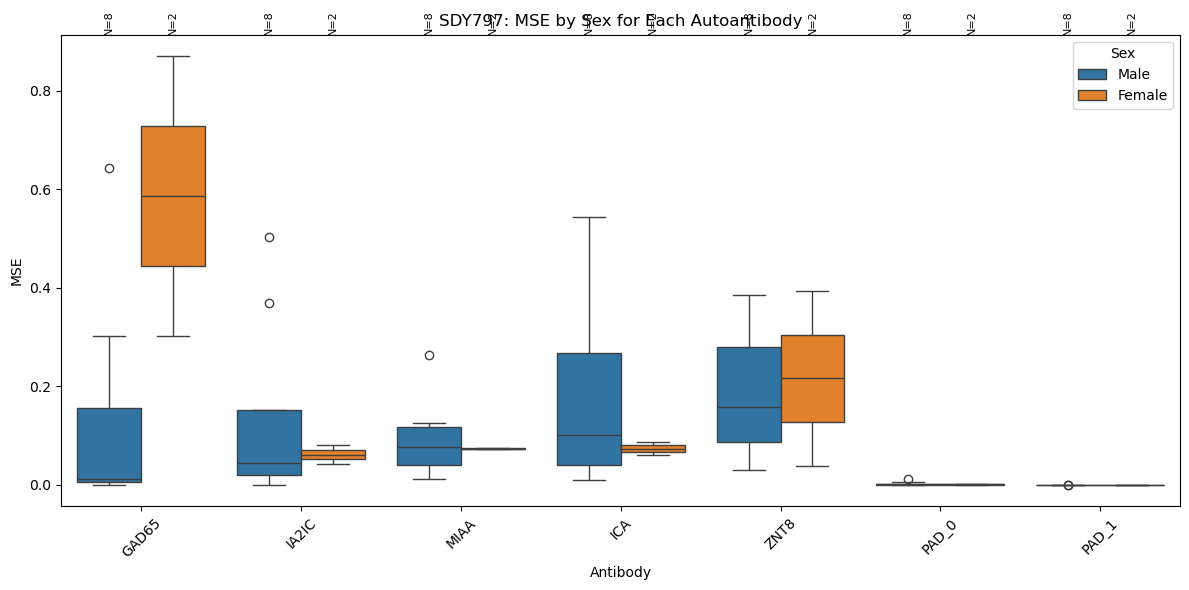

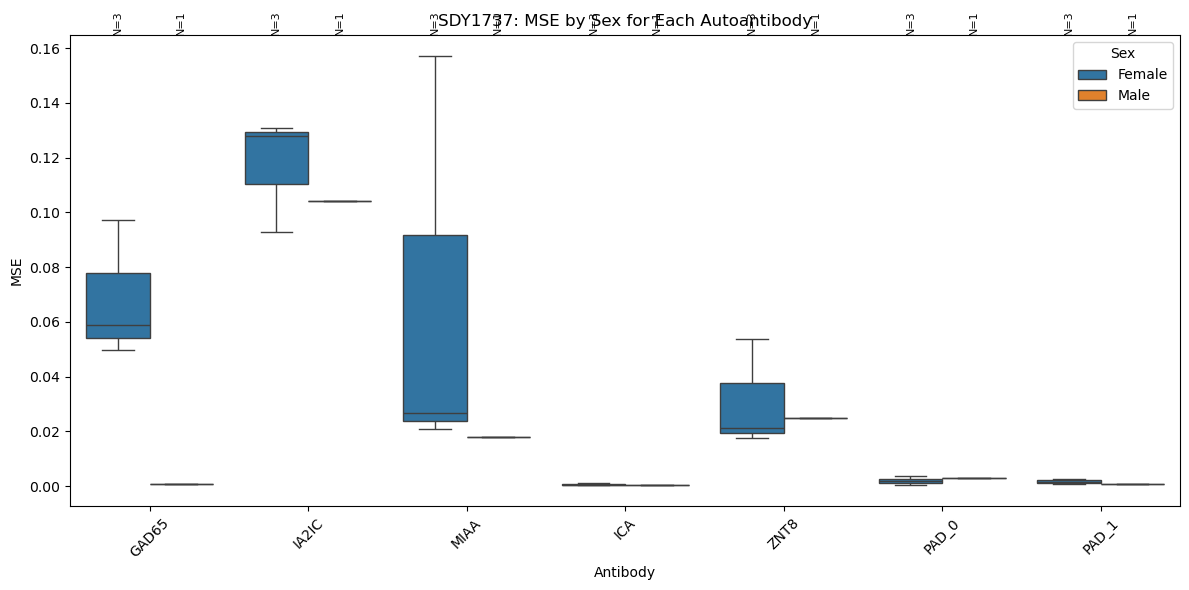

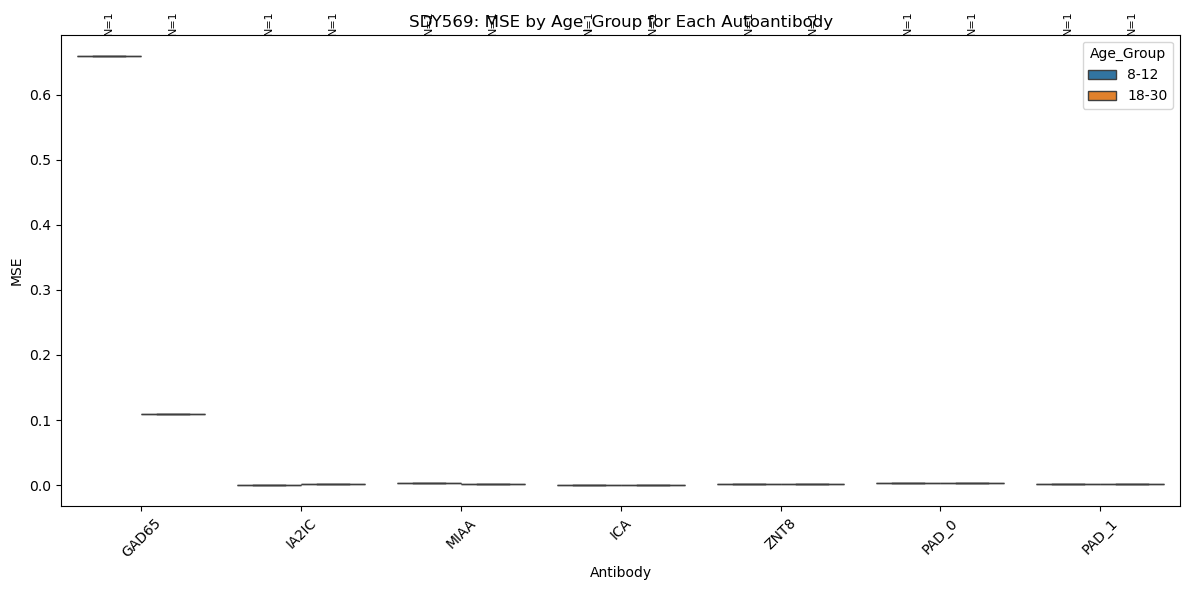

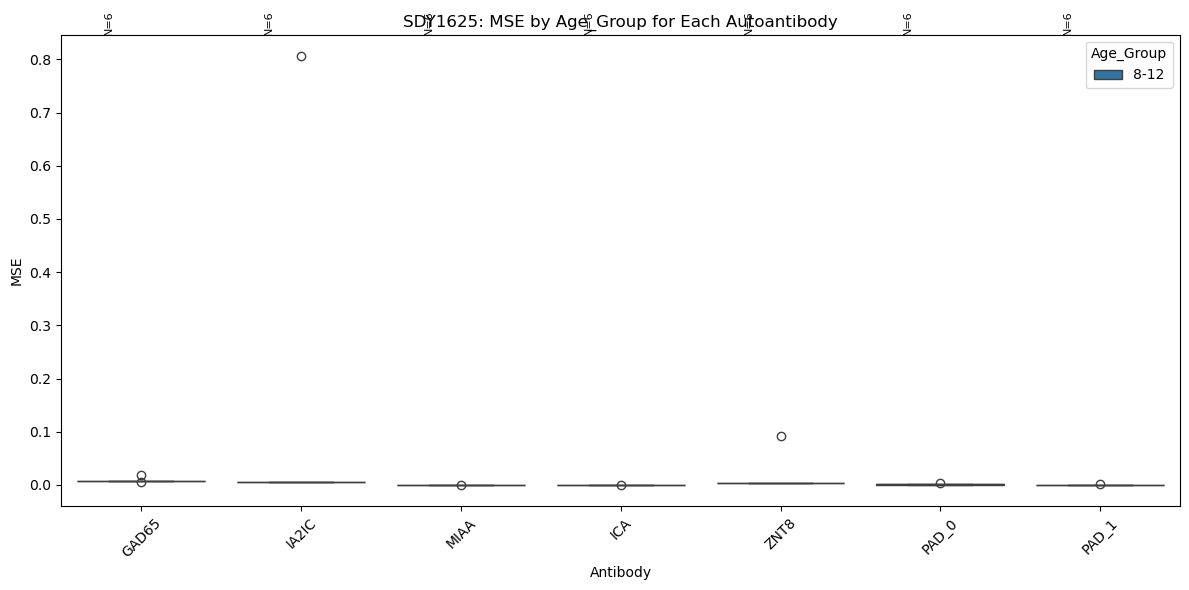

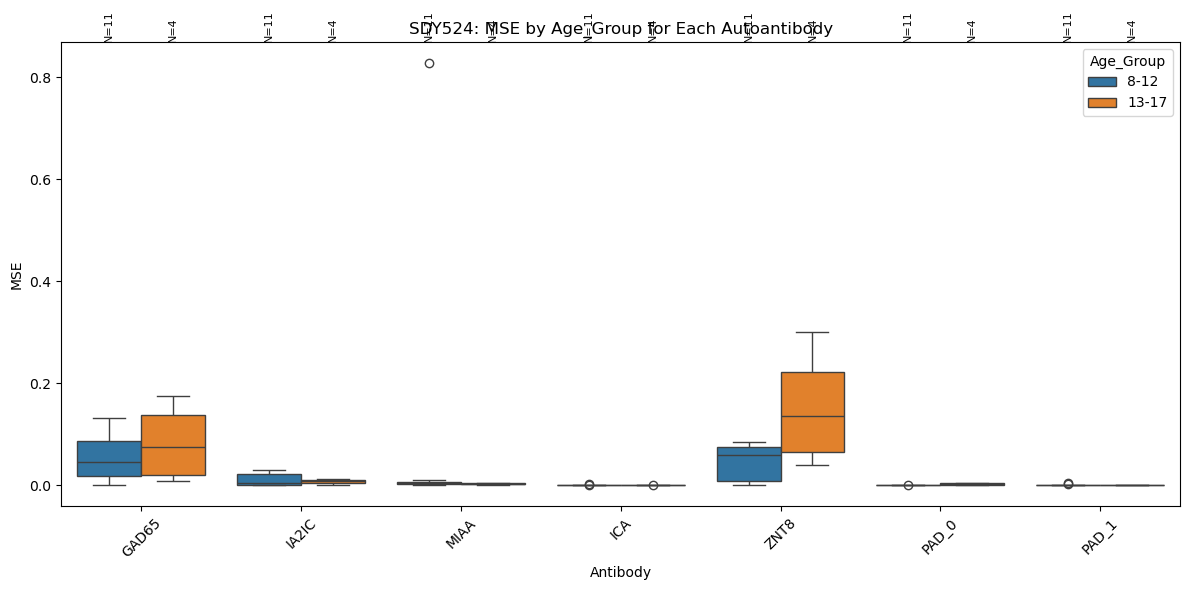

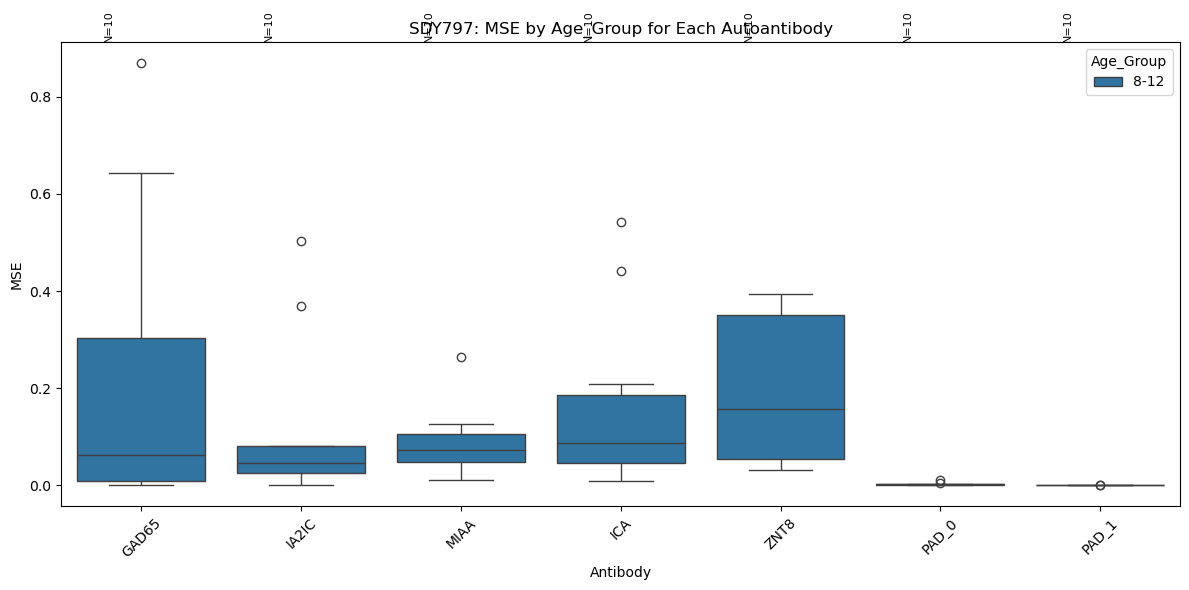

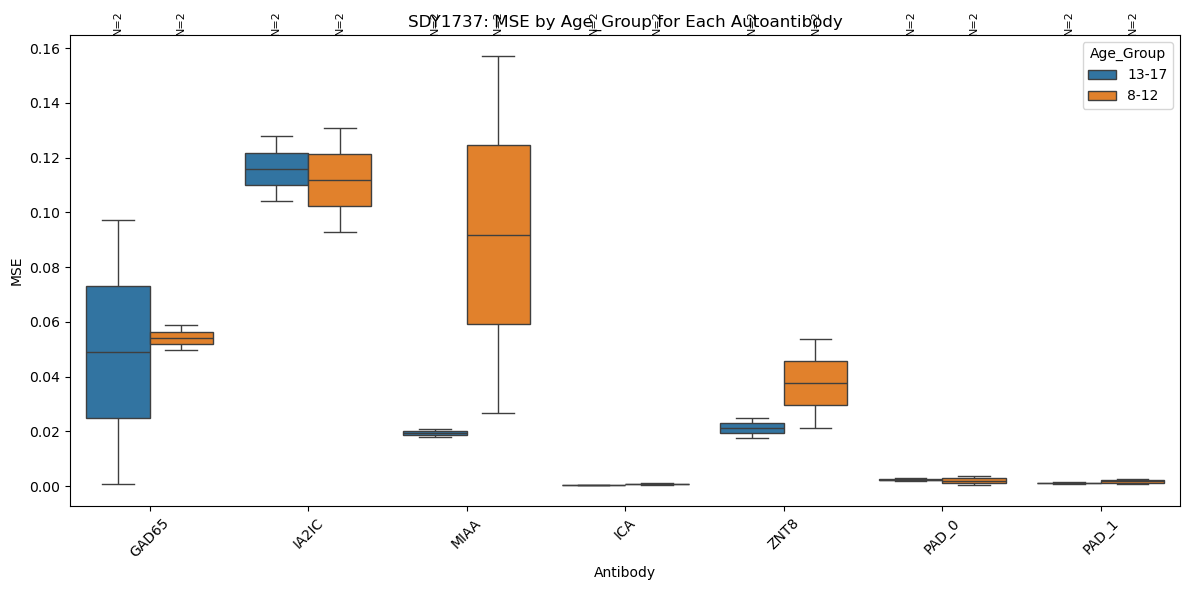

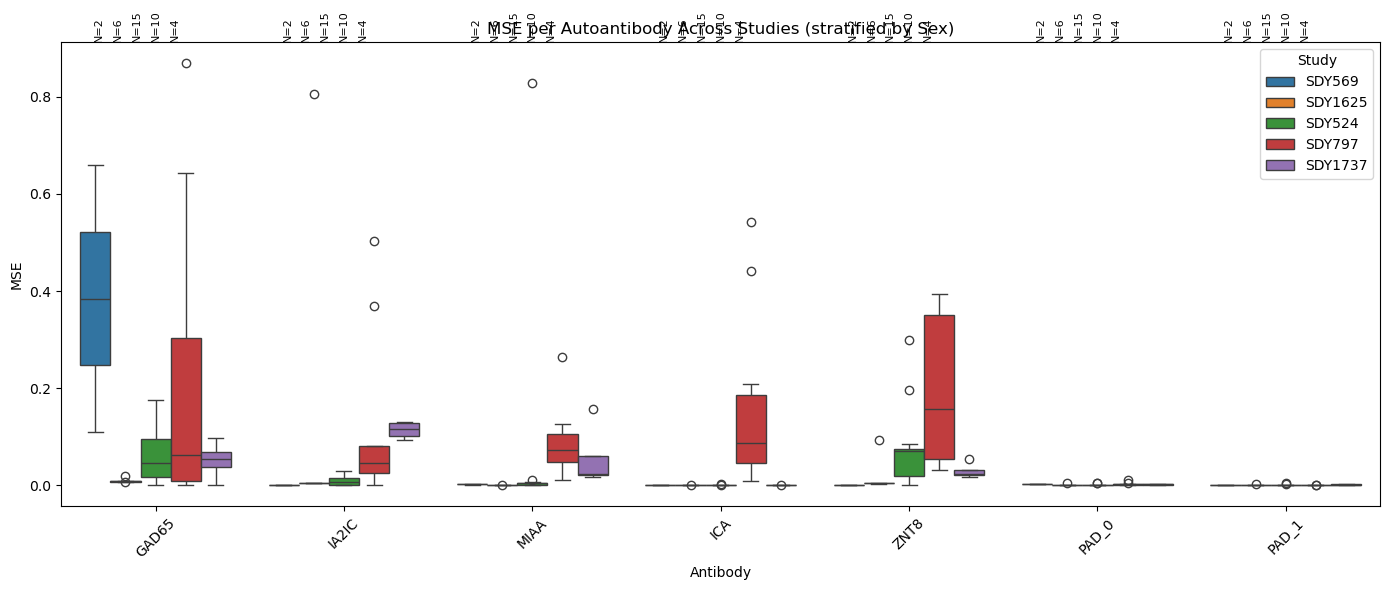

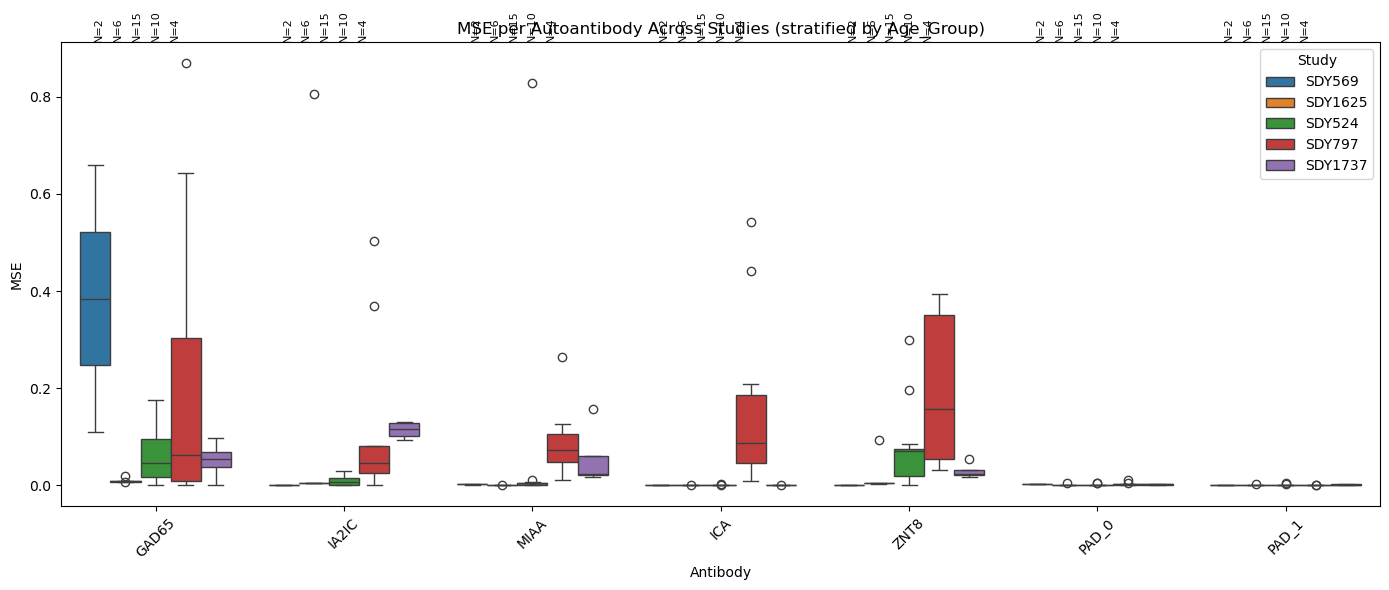

In [21]:
# Plot per-study, stratified
plot_per_study_mse_stratified(mse_summaries, stratify_by="Sex")
plot_per_study_mse_stratified(mse_summaries, stratify_by="Age_Group")

# Across-study, stratified
antibody_mse_across_studies(mse_summaries, stratify_by="Sex")
antibody_mse_across_studies(mse_summaries, stratify_by="Age_Group")


In [22]:
def extract_model_weights_per_study(mse_summaries):
    weights_dict = {}

    for study, summary in mse_summaries.items():
        # This assumes that you stored the trained Keras model file per study
        model_path = f"models/{study}_model.keras"

        try:
            from tensorflow.keras.models import load_model
            model = load_model(model_path)

            weights = model.get_weights()
            weights_dict[study] = weights
        except Exception as e:
            print(f"Could not load model for {study}: {e}")
            weights_dict[study] = None

    return weights_dict


In [23]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model

def summarize_model_weights(weights_dict):
    summary_rows = []

    for study, weights in weights_dict.items():
        if weights is None:
            summary_rows.append({"Study": study, "Layer": "N/A", "Shape": "N/A", "Params": "N/A"})
            continue

        for i, w in enumerate(weights):
            summary_rows.append({
                "Study": study,
                "Layer": f"{i}",
                "Shape": str(w.shape),
                "Params": np.prod(w.shape)
            })

    df_summary = pd.DataFrame(summary_rows)
    return df_summary


In [24]:
def extract_model_weights_per_study(mse_summaries):
    weights_dict = {}

    for study in mse_summaries.keys():
        model_path = f"models/{study}_model.keras"

        try:
            model = load_model(model_path)
            weights = model.get_weights()
            weights_dict[study] = weights
        except Exception as e:
            print(f"Could not load model for {study}: {e}")
            weights_dict[study] = None

    return weights_dict


In [25]:
weights_dict = extract_model_weights_per_study(mse_summaries)
df_weights = summarize_model_weights(weights_dict)
display(df_weights)


,Study,Layer,Shape,Params
0,SDY569,0,"(3, 1, 1, 4)",12
1,SDY569,1,"(4,)",4
2,SDY569,2,"(28, 2)",56
3,SDY569,3,"(2,)",2
4,SDY569,4,"(2, 28)",56
5,SDY569,5,"(28,)",28
6,SDY569,6,"(3, 1, 4, 1)",12
7,SDY569,7,"(1,)",1
8,SDY1625,0,"(3, 1, 1, 4)",12
9,SDY1625,1,"(4,)",4


In [26]:
import pandas as pd

# Assuming you already have weights_summary (from previous cell or code)
df_weights.to_csv("data/df_weights.csv", index=False)
print("Saved data/df_weights.csv")


Saved data/df_weights.csv


In [27]:
import pandas as pd
import numpy as np
import os

def export_weights_to_csv(weights_dict, output_dir="weights_by_study"):
    os.makedirs(output_dir, exist_ok=True)

    for study, weights_list in weights_dict.items():
        if weights_list is None:
            print(f"Skipping {study}: no weights.")
            continue

        rows = []
        layer_idx = 0

        # Keras stores [weights, bias] pairs for each layer
        for i in range(0, len(weights_list), 2):
            W = weights_list[i]
            b = weights_list[i + 1] if i + 1 < len(weights_list) else None

            # Flatten weights
            for idx, val in np.ndenumerate(W):
                rows.append({
                    "Study": study,
                    "Layer": f"layer_{layer_idx}",
                    "Param": "weight",
                    "Index": str(idx),
                    "Value": val
                })

            # Flatten biases
            if b is not None:
                for idx, val in np.ndenumerate(b):
                    rows.append({
                        "Study": study,
                        "Layer": f"layer_{layer_idx}",
                        "Param": "bias",
                        "Index": str(idx),
                        "Value": val
                    })

            layer_idx += 1

        # Save to CSV
        df_weights = pd.DataFrame(rows)
        file_path = os.path.join(output_dir, f"weights_{study}.csv")
        df_weights.to_csv(file_path, index=False)
        print(f"Saved weights to: {file_path}")

# Run the function
export_weights_to_csv(weights_dict)


Saved weights to: weights_by_study/weights_SDY569.csv
Saved weights to: weights_by_study/weights_SDY1625.csv
Saved weights to: weights_by_study/weights_SDY524.csv
Saved weights to: weights_by_study/weights_SDY797.csv
Saved weights to: weights_by_study/weights_SDY1737.csv
